In [1]:
!pip install shap

In [72]:
from collections import Counter, defaultdict
from typing import List, Dict, Literal, Union

import re
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import shap

import warnings

warnings.filterwarnings("ignore")

CACHE_DIR = "./cache"

In [3]:
!pip install gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import LdaModel

nltk.download('stopwords')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 91.1 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.7 MB/s eta 0:00:00


In [5]:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

# Data

In [7]:
ds = load_dataset("UniverseTBD/arxiv-abstracts-large", cache_dir=CACHE_DIR)
ds

README.md:   0%|          | 0.00/810 [00:00<?, ?B/s]

arxiv-metadata-oai-snapshot.json:   0%|          | 0.00/3.82G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2292057 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [8]:
for i in range(3):
    print(f"Example {i+1}:")
    print(ds['train'][i]['abstract'])
    print(ds['train'][i]['categories'])
    print("---" * 20)

Example 1:
  A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of events.

hep-p

In [9]:
all_categories = ds['train']['categories'][:500]
print(set(all_categories))

{'physics.gen-ph quant-ph', 'math.AT', 'cs.CC', 'nucl-ex hep-ex', 'nucl-th hep-ph', 'hep-ph hep-lat nucl-th', 'nucl-th', 'cond-mat.other hep-th quant-ph', 'quant-ph math-ph math.MP', 'cond-mat.supr-con', 'math.CO cs.CG', 'cond-mat.stat-mech cond-mat.soft physics.chem-ph', 'cond-mat.mes-hall cond-mat.str-el', 'hep-ph astro-ph hep-th', 'cs.CE cond-mat.stat-mech cs.MS cs.NA physics.data-an', 'nlin.PS', 'math.PR', 'math.GR', 'math.NT', 'physics.gen-ph', 'cs.IT cs.CC math.IT', 'math.MG', 'math.PR math.CA math.ST stat.TH', 'physics.chem-ph physics.flu-dyn', 'cond-mat.str-el cond-mat.stat-mech', 'math.CA math.AT', 'cond-mat.soft cond-mat.mtrl-sci', 'math.FA math.SP', 'nlin.SI', 'cond-mat.mtrl-sci cond-mat.stat-mech', 'cond-mat.supr-con cond-mat.mes-hall', 'math.RT math.RA', 'math.DG math.RT', 'astro-ph physics.ao-ph', 'cond-mat.dis-nn cond-mat.stat-mech', 'cond-mat.str-el cond-mat.mtrl-sci', 'quant-ph hep-th nlin.CD physics.atom-ph physics.chem-ph', 'physics.bio-ph physics.data-an q-bio.BM', 

In [10]:
all_categories = ds['train']['categories']
category_set = set()

for category in all_categories:
    parts = category.split(' ')
    for part in parts:
        topic = part.split('.')[0]
        category_set.add(topic)

sorted_categories= sorted(list(category_set), key=lambda x: x.lower())
print(f'There are {len(sorted_categories)} unique primary categories in the dataset:')
for category in sorted_categories:
    print(category)

There are 38 unique primary categories in the dataset:
acc-phys
adap-org
alg-geom
ao-sci
astro-ph
atom-ph
bayes-an
chao-dyn
chem-ph
cmp-lg
comp-gas
cond-mat
cs
dg-ga
econ
eess
funct-an
gr-qc
hep-ex
hep-lat
hep-ph
hep-th
math
math-ph
mtrl-th
nlin
nucl-ex
nucl-th
patt-sol
physics
plasm-ph
q-alg
q-bio
q-fin
quant-ph
solv-int
stat
supr-con


In [11]:
# load 1000 samples with single label belonging to specific categories
samples = []
CATEGORIES_TO_SELECT = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
for s in ds['train']:
    if len(s['categories'].split(' ')) != 1:
        continue

    cur_category = s['categories'].strip().split('.')[0]
    if cur_category not in CATEGORIES_TO_SELECT:
        continue

    samples.append(s)

    if len(samples) >= 500:
        break
print(f"Number of samples: {len(samples)}")

for sample in samples[:3]:
    print(f"Category: {sample['categories']}")
    print("Abstract:", sample['abstract'])
    print("#" * 20 + "\n")

Number of samples: 500
Category: physics.gen-ph
Abstract:   The evolution of Earth-Moon system is described by the dark matter field
fluid model proposed in the Meeting of Division of Particle and Field 2004,
American Physical Society. The current behavior of the Earth-Moon system agrees
with this model very well and the general pattern of the evolution of the
Moon-Earth system described by this model agrees with geological and fossil
evidence. The closest distance of the Moon to Earth was about 259000 km at 4.5
billion years ago, which is far beyond the Roche's limit. The result suggests
that the tidal friction may not be the primary cause for the evolution of the
Earth-Moon system. The average dark matter field fluid constant derived from
Earth-Moon system data is 4.39 x 10^(-22) s^(-1)m^(-1). This model predicts
that the Mars's rotation is also slowing with the angular acceleration rate
about -4.38 x 10^(-22) rad s^(-2).

####################

Category: math.CO
Abstract:   We show t

In [12]:
preprocessed_samples = []
for s in samples:
  abstract = s['abstract']
  abstract = abstract.strip().replace("\n", " ")
  abstract = re.sub(r'[^\w\s]', '', abstract)
  abstract = re.sub(r'\d+', '', abstract)
  abstract = re.sub(r'\s+', ' ', abstract).strip()
  abstract = abstract.lower()
  parts = s['categories'].split(' ')
  category = parts[0].split('.')[0]

  preprocessed_samples.append({
      "text": abstract,
      "label": category
  })

In [13]:
for sample in preprocessed_samples[:3]:
    print(f"Label: {sample['label']}")
    print("Text:", sample['text'])
    print("#" * 20 + "\n")

Label: physics
Text: the evolution of earthmoon system is described by the dark matter field fluid model proposed in the meeting of division of particle and field american physical society the current behavior of the earthmoon system agrees with this model very well and the general pattern of the evolution of the moonearth system described by this model agrees with geological and fossil evidence the closest distance of the moon to earth was about km at billion years ago which is far beyond the roches limit the result suggests that the tidal friction may not be the primary cause for the evolution of the earthmoon system the average dark matter field fluid constant derived from earthmoon system data is x sm this model predicts that the marss rotation is also slowing with the angular acceleration rate about x rad s
####################

Label: math
Text: we show that a determinant of stirling cycle numbers counts unlabeled acyclic singlesource automata the proof involves a bijection from 

In [14]:
labels = set([s['label'] for s in preprocessed_samples])
sorted_labels = sorted(labels)
for label in sorted_labels:
    print(label)

astro-ph
cond-mat
cs
math
physics


In [15]:
label_to_id = {label: i for i, label in enumerate(sorted_labels)}
id_to_label = {i: label for i, label in enumerate(sorted_labels)}

print("Label to ID mapping:")
for label, id_ in label_to_id.items():
    print(f"{label} --> {id_}")

Label to ID mapping:
astro-ph --> 0
cond-mat --> 1
cs --> 2
math --> 3
physics --> 4


In [16]:
X_full = [sample['text'] for sample in preprocessed_samples]
y_full = [label_to_id[sample['label']] for sample in preprocessed_samples]

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 400
Test samples: 100


# Dataset Analysis

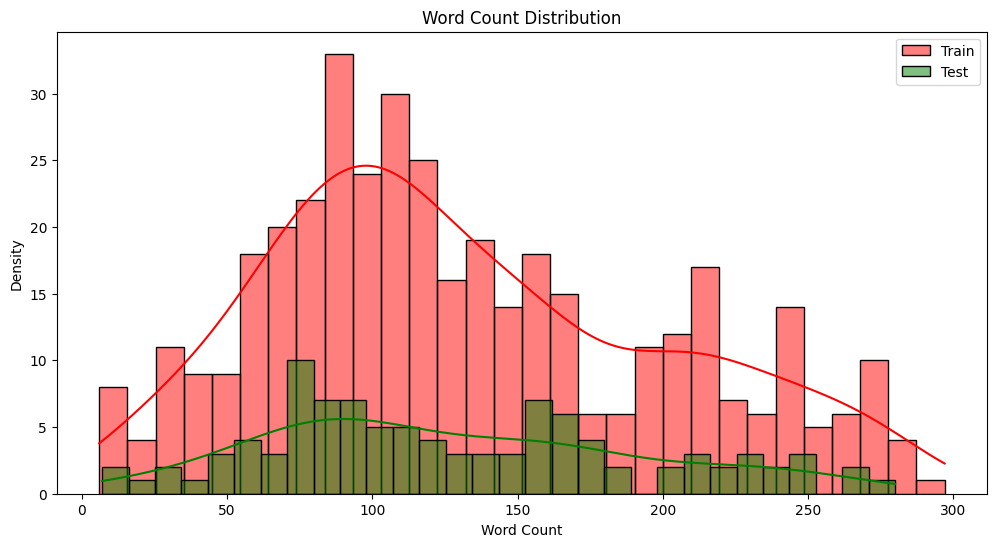

In [17]:
train_word_counts = [len(text.split()) for text in X_train]
test_word_counts = [len(text.split()) for text in X_test]
plt.figure(figsize=(12, 6))
sns.histplot(train_word_counts, color='red', label='Train', kde=True, stat="count", bins=30)
sns.histplot(test_word_counts, color='green', label='Test', kde=True, stat="count", bins=30)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.savefig('word_count_distribution.png')
plt.show()

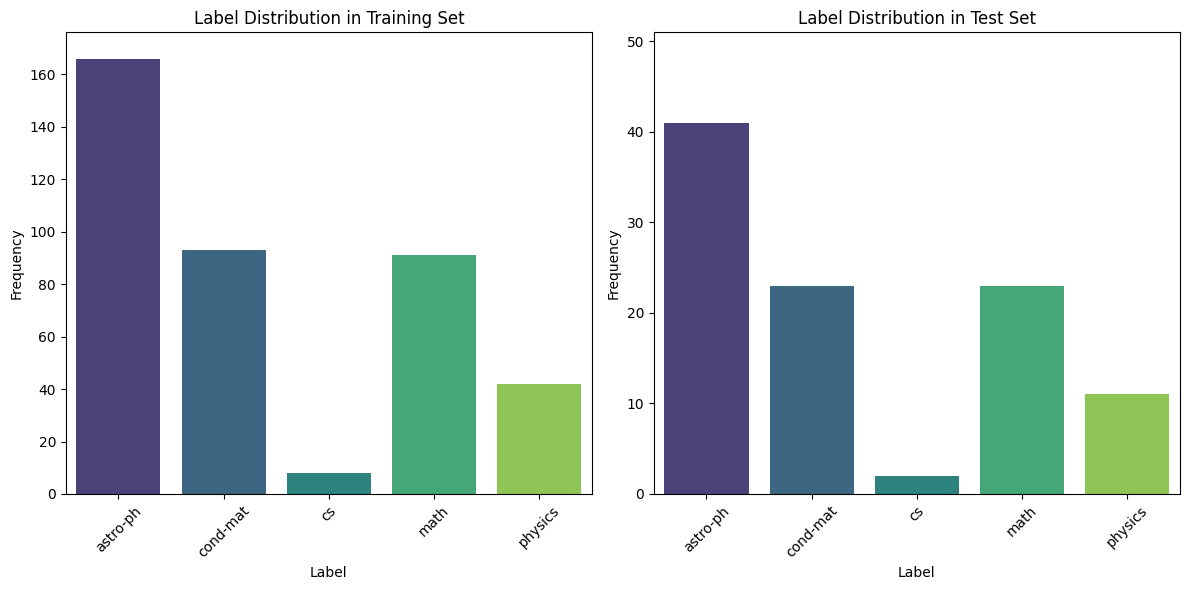

In [18]:
plt.figure(figsize=(12, 6))
train_label_counts = Counter(y_train)
test_label_counts = Counter(y_test)

plt.subplot(1, 2, 1)
sns.barplot(x=list(train_label_counts.keys()), y=list(train_label_counts.values()), palette='viridis')
plt.title('Label Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=list(train_label_counts.keys()), labels=[id_to_label[i] for i in train_label_counts.keys()], rotation=45)
plt.ylim(0, max(train_label_counts.values()) + 10)

plt.subplot(1, 2, 2)
sns.barplot(x=list(test_label_counts.keys()), y=list(test_label_counts.values()), palette='viridis')
plt.title('Label Distribution in Test Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=list(test_label_counts.keys()), labels=[id_to_label[i] for i in test_label_counts.keys()], rotation=45)
plt.ylim(0, max(test_label_counts.values()) + 10)

plt.tight_layout()
plt.savefig('label_distribution.png')
plt.show()

Top 10 most frequently occurring words in the training set:
model: 164
results: 153
using: 144
also: 138
emission: 132
field: 128
mass: 127
data: 123
show: 121
stars: 121


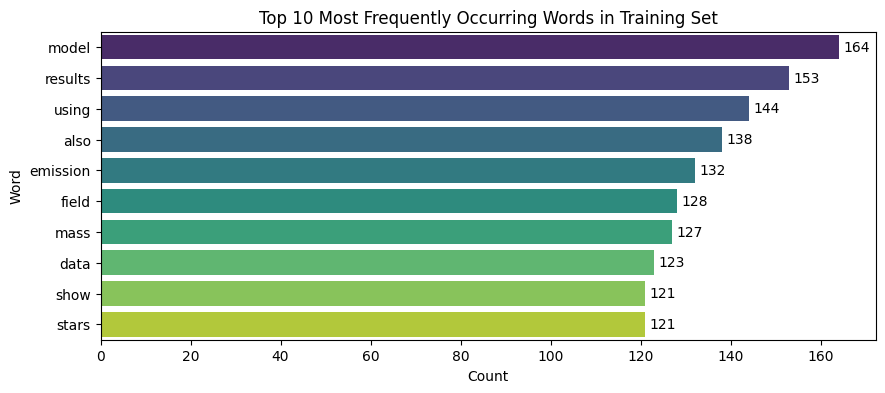

In [19]:
stop_words = set(stopwords.words('english'))

word_counts = Counter()
for text in [*X_train, *X_test]:
    words = text.split()
    words = [word for word in words if word not in stop_words]
    word_counts.update(words)
most_common_words = word_counts.most_common(10)

print("Top 10 most frequently occurring words in the training set:")
for word, count in most_common_words:
    print(f"{word}: {count}")

plt.figure(figsize=(10, 4))
words, counts = zip(*most_common_words)
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Top 10 Most Frequently Occurring Words in Training Set')
plt.xlabel('Count')
plt.ylabel('Word')
for i, count in enumerate(counts):
    plt.text(count + 1, i, str(count), va='center')
plt.savefig('top_10_words.png')
plt.show()

In [20]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

lda_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words="english")
document_term_matrix = lda_vectorizer.fit_transform(X_train)

lda = LatentDirichletAllocation(
    n_components=5,
    random_state=42
)
lda.fit(document_term_matrix)
feature_names = lda_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    for index, topic in enumerate(model.components_):
        print(f'The top {no_top_words} words for topic #{index}')
        print([feature_names[i] for i in topic.argsort()[-no_top_words:]], '\n')

display_topics(lda, feature_names, no_top_words=10)

The top 10 words for topic #0
['structure', 'function', 'present', 'observed', 'xray', 'using', 'results', 'data', 'order', 'emission'] 

The top 10 words for topic #1
['functions', 'model', 'high', 'structure', 'redshift', 'galaxies', 'field', 'energy', 'time', 'local'] 

The top 10 words for topic #2
['data', 'methods', 'method', 'new', 'field', 'paper', 'use', 'using', 'results', 'velocity'] 

The top 10 words for topic #3
['state', 'observations', 'surface', 'temperature', 'spin', 'using', 'field', 'magnetic', 'mass', 'model'] 

The top 10 words for topic #4
['observed', 'formation', 'new', 'clusters', 'stellar', 'cluster', 'mass', 'stars', 'galaxies', 'star'] 



In [21]:
topic_results = lda.transform(document_term_matrix)
topic_results

array([[0.59835576, 0.00182537, 0.00182835, 0.00184768, 0.39614284],
       [0.00237526, 0.00238383, 0.00239319, 0.47659832, 0.5162494 ],
       [0.97610366, 0.00601928, 0.00598517, 0.00592908, 0.00596282],
       ...,
       [0.00161171, 0.00160223, 0.00160209, 0.99357064, 0.00161333],
       [0.91858133, 0.02016828, 0.02086588, 0.020321  , 0.02006352],
       [0.00336581, 0.00334034, 0.00332959, 0.98663971, 0.00332455]])

In [22]:
stop_words = set(stopwords.words('english'))

def preprocess(document):
    lemmatizer = WordNetLemmatizer()
    tokens = [t for t in simple_preprocess(document) if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

processed_docs = [preprocess(d) for d in X_train]
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=42,
    passes=20,
    iterations=400,
    alpha='auto',
    per_word_topics=True
)

for i, topic in lda_model.show_topics(formatted=False, num_words=10):
    print(f'Topic {i}: {[word for word, _ in topic]}')

Topic 0: ['spin', 'temperature', 'state', 'energy', 'field', 'result', 'vortex', 'range', 'galaxy', 'using']
Topic 1: ['cluster', 'model', 'star', 'galaxy', 'result', 'group', 'method', 'show', 'system', 'using']
Topic 2: ['star', 'planet', 'line', 'observation', 'model', 'disk', 'source', 'result', 'velocity', 'emission']
Topic 3: ['model', 'galaxy', 'result', 'energy', 'mass', 'study', 'surface', 'temperature', 'emission', 'star']
Topic 4: ['period', 'spectrum', 'state', 'data', 'magnetic', 'source', 'function', 'spin', 'two', 'neutrino']
Topic 5: ['field', 'result', 'cluster', 'star', 'number', 'model', 'show', 'gas', 'co', 'disk']
Topic 6: ['model', 'quasar', 'star', 'source', 'line', 'observed', 'velocity', 'observation', 'galaxy', 'field']
Topic 7: ['source', 'emission', 'high', 'show', 'object', 'region', 'observation', 'energy', 'star', 'low']
Topic 8: ['mass', 'galaxy', 'result', 'function', 'planet', 'using', 'time', 'xray', 'new', 'data']
Topic 9: ['system', 'planet', 'magne

In [23]:
topic_predictions = lda_model.get_document_topics(corpus)
for i in range(10):
    print(f"Document {i+1} topic distribution: {topic_predictions[i]}")

Document 1 topic distribution: [(2, np.float32(0.28067157)), (5, np.float32(0.65661716)), (6, np.float32(0.06145845))]
Document 2 topic distribution: [(2, np.float32(0.2568048)), (7, np.float32(0.7412053))]
Document 3 topic distribution: [(5, np.float32(0.9949831))]
Document 4 topic distribution: [(0, np.float32(0.9948962))]
Document 5 topic distribution: [(5, np.float32(0.99862915))]
Document 6 topic distribution: [(4, np.float32(0.99076027))]
Document 7 topic distribution: [(0, np.float32(0.083366685)), (8, np.float32(0.9143796))]
Document 8 topic distribution: [(8, np.float32(0.998352))]
Document 9 topic distribution: [(0, np.float32(0.99621016))]
Document 10 topic distribution: [(0, np.float32(0.9969017))]


In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.009602  0.004671       1        1  14.133643
8      0.016964 -0.083929       2        1  12.191413
1     -0.015565 -0.037901       3        1  11.571927
6      0.041002  0.026574       4        1  10.738553
2      0.086016 -0.056023       5        1   9.772043
0     -0.137716 -0.046682       6        1   9.588847
3     -0.050878 -0.017044       7        1   9.010419
9      0.012834  0.026850       8        1   8.408562
4     -0.057690  0.134745       9        1   7.405764
7      0.095429  0.048739      10        1   7.178830, topic_info=         Term       Freq       Total Category  logprob  loglift
446    planet  60.000000   60.000000  Default  30.0000  30.0000
1074  cluster  93.000000   93.000000  Default  29.0000  29.0000
152      spin  51.000000   51.000000  Default  28.0000  28.0000
1252   quasar  26.000000   26.000000  Default  27.0000  27.0000
153     state  72.000000   72.000000  Default  26.0000  26.0000
...       ...        ...         ...      ...      ...      ...
122    method   7.628218   73.132054  Topic10  -5.6656   0.3736
746     three   6.148312   31.427535  Topic10  -5.8813   1.0025
687       one   7.146962   65.510595  Topic10  -5.7307   0.4185
51       mass   7.324375  111.129171  Topic10  -5.7062  -0.0855
1074  cluster   7.142843   93.802102  Topic10  -5.7313   0.0590

[766 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1230      9  0.625555    absorber
92        1  0.132980  absorption
92        3  0.132980  absorption
92        4  0.365695  absorption
92        5  0.033245  absorption
...     ...       ...         ...
5371     10  0.948071        ysos
2723      8  0.737982      z_odot
3556      7  0.914039        zdtp
3300      7  0.871901      zsolar
2074      1  0.924615          zw

[1908 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 2, 7, 3, 1, 4, 10, 5, 8])

# Text Encoder

Bag of Words (BoW) is a simple and commonly used text representation technique. It converts text into a fixed-length vector by counting the occurrences of each word in the text. This method ignores grammar and word order but retains the frequency of words.

In [25]:
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

bow = CountVectorizer()
vectors = bow.fit_transform(docs)

for i, vec in enumerate(vectors):
    print(f"Document {i+1}: {vec.toarray()}")

Document 1: [[1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 2 0 0 0]]
Document 2: [[0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0]]
Document 3: [[0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0]]
Document 4: [[0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1]]


Tf-idf (Term Frequency-Inverse Document Frequency) is another popular text representation technique. It not only considers the frequency of words in a document but also how common or rare a word is across all documents. This helps to reduce the weight of common words and highlight more informative ones.

In [26]:
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

vectorizer = TfidfVectorizer()
tfidf_vectors = vectorizer.fit_transform(docs)

for i, vec in enumerate(tfidf_vectors):
    print(f"TF-IDF for Document {i+1}:")
    print(vec.toarray())

TF-IDF for Document 1:
[[0.29333722 0.         0.         0.         0.29333722 0.
  0.         0.         0.         0.29333722 0.29333722 0.29333722
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.29333722
  0.         0.29333722 0.23127044 0.58667444 0.         0.
  0.        ]]
TF-IDF for Document 2:
[[0.         0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.38166888 0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.         0.         0.30091213 0.         0.38166888 0.38166888
  0.        ]]
TF-IDF for Document 3:
[[0.         0.         0.2855815  0.         0.         0.
  0.36222393 0.         0.         0.         0.         0.
  0.         0.36222393 0.         0.36222393 0.36222393 0.
  0.36222393 0.         0.         0.36222393 0.36222393 0.
  0.         0.         0.         0.

Word embeddings are dense vector representations of words that capture semantic relationships between them. They are typically pre-trained on large corpora and can be used to represent words in a continuous vector space, allowing for better generalization and understanding of word meanings.

In [27]:
class EmbeddingVectorizer:
    def __init__(
        self,
        model_name: str = 'intfloat/multilingual-e5-base',
        normalize: bool = True
    ):
        self.model = SentenceTransformer(model_name)
        self.normalize = normalize

    def _format_inputs(
        self,
        texts: List[str],
        mode: Literal['query', 'passage']
    ) -> List[str]:
        if mode not in {"query", "passage"}:
            raise ValueError("Mode must be either 'query' or 'passage'")
        return [f"{mode}: {text.strip()}" for text in texts]

    def transform(
        self,
        texts: List[str],
        mode: Literal['query', 'passage'] = 'query'
    ) -> List[List[float]]:
        if mode == 'raw':
            inputs = texts
        else:
            inputs = self._format_inputs(texts, mode)

        embeddings = self.model.encode(inputs, normalize_embeddings=self.normalize)
        return embeddings.tolist()

    def transform_numpy(
        self,
        texts: List[str],
        mode: Literal['query', 'passage'] = 'query'
    ) -> np.ndarray:
        return np.array(self.transform(texts, mode=mode))

In [28]:
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

vectorizer = EmbeddingVectorizer()
embeddings = vectorizer.transform(docs)

for i, emb in enumerate(embeddings):
    print(f"Embedding for Document {i+1}:")
    print(emb[:10])
    print("#" * 20)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Embedding for Document 1:
[-0.014805697835981846, 0.03127659484744072, -0.016158660873770714, 0.007545319385826588, 0.04465828835964203, -0.05123654007911682, -0.014604968018829823, -0.04828919842839241, 0.05034762993454933, 0.0047388700768351555]
####################
Embedding for Document 2:
[0.011917391791939735, 0.033273596316576004, -0.02573901042342186, 0.026533057913184166, 0.0316096656024456, -0.021373162046074867, -0.012149748392403126, -0.03784850612282753, 0.04151839017868042, 1.3289674825500697e-05]
####################
Embedding for Document 3:
[0.012662903405725956, 0.03936120867729187, -0.024181151762604713, 0.01619776152074337, 0.007417706307023764, -0.030312353745102882, -0.014685511589050293, -0.03850284218788147, 0.0069724260829389095, 0.01775604858994484]
####################
Embedding for Document 4:
[0.0063936361111700535, 0.04922199994325638, -0.028402933850884438, -0.013305905275046825, 0.0058109755627810955, -0.043715108186006546, -0.008321727626025677, -0.0413

In [29]:
bow_vectorizer = CountVectorizer(
    stop_words="english",
    max_df=0.9,
    min_df=2,
    max_features=3000
)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.9,
    min_df=2,
    max_features=3000
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

embedding_vectorizer = EmbeddingVectorizer()
X_train_embeddings = embedding_vectorizer.transform(X_train)
X_test_embeddings = embedding_vectorizer.transform(X_test)

# convert all to numpy arrays for consistency
X_train_bow, X_test_bow = np.array(X_train_bow.toarray()), np.array(X_test_bow.toarray())
X_train_tfidf, X_test_tfidf = np.array(X_train_tfidf.toarray()), np.array(X_test_tfidf.toarray())
X_train_embeddings, X_test_embeddings = np.array(X_train_embeddings), np.array(X_test_embeddings)

# Print shapes of the transformed datasets
print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}\n")
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}\n")
print(f"Shape of X_train_embeddings: {X_train_embeddings.shape}")
print(f"Shape of X_test_embeddings: {X_test_embeddings.shape}\n")

Shape of X_train_bow: (400, 2882)
Shape of X_test_bow: (100, 2882)

Shape of X_train_tfidf: (400, 2882)
Shape of X_test_tfidf: (100, 2882)

Shape of X_train_embeddings: (400, 768)
Shape of X_test_embeddings: (100, 768)



# Train ML Models

In [31]:
def plot_confusion_matrix(y_true, y_pred, label_list, figure_name="Confusion Matrix", save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    labels = np.unique(y_true)
    if isinstance(label_list, dict):
        class_names = [label_list[i] for i in labels]
    else:
        class_names = [label_list[i] for i in labels]

    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            raw = cm[i, j]
            norm = cm_normalized[i, j]
            annotations[i, j] = f"{raw}\n({norm:.2%})"

    # Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=annotations, fmt="", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, linewidths=1, linecolor='black')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(figure_name)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()

# KMean Clustering

## KMean là thuật toán phân cụm không giám sát, nó phân chia các vector thành các cụm dựa trên khoảng cách giữa chúng.

In [39]:
from sklearn.cluster import KMeans
def train_and_test_kmeans(X_train, y_train, X_test, y_test, n_clusters: int):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_ids = kmeans.fit_predict(X_train)

    # Assign label to clusters
    cluster_to_label = {}
    for cluster_id in set(cluster_ids):
        # Get all labels in this cluster
        labels_in_cluster = [y_train[i] for i in range(len(y_train)) if cluster_ids[i] == cluster_id]
        most_common_label = Counter(labels_in_cluster).most_common(1)[0][0]
        cluster_to_label[cluster_id] = most_common_label

    test_cluster_ids = kmeans.predict(X_test)
    y_pred = [cluster_to_label[cluster_id] for cluster_id in test_cluster_ids]
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=[id_to_label[i] for i in range(len(id_to_label))], output_dict=True)

    return y_pred, accuracy, report

In [40]:
# Train and test K-Means on different vectorized datasets
km_bow_labels, km_bow_accuracy, km_bow_report = train_and_test_kmeans(X_train_bow, y_train, X_test_bow, y_test, n_clusters=len(label_to_id))
km_tfidf_labels, km_tfidf_accuracy, km_tfidf_report = train_and_test_kmeans(X_train_tfidf, y_train, X_test_tfidf, y_test, n_clusters=len(label_to_id))
km_embeddings_labels, km_embeddings_accuracy, km_embeddings_report = train_and_test_kmeans(X_train_embeddings, y_train, X_test_embeddings, y_test, n_clusters=len(label_to_id))
# Print K-Means results
print("Accuracies for K-Means:")
print(f"Bag of Words: {km_bow_accuracy:.4f}")
print(f"TF-IDF: {km_tfidf_accuracy:.4f}")
print(f"Embeddings: {km_embeddings_accuracy:.4f}")

Accuracies for K-Means:
Bag of Words: 0.4500
TF-IDF: 0.7600
Embeddings: 0.8000


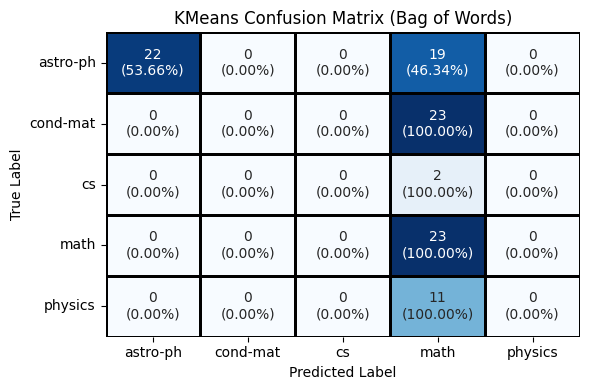

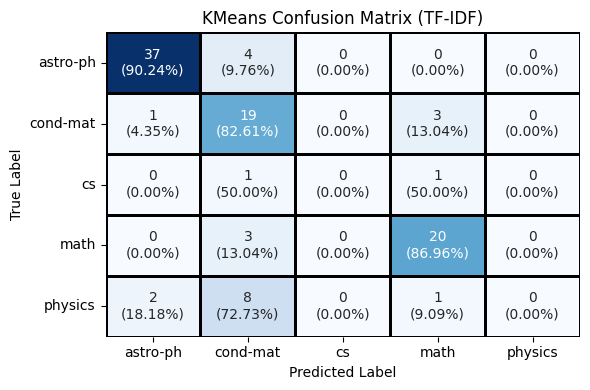

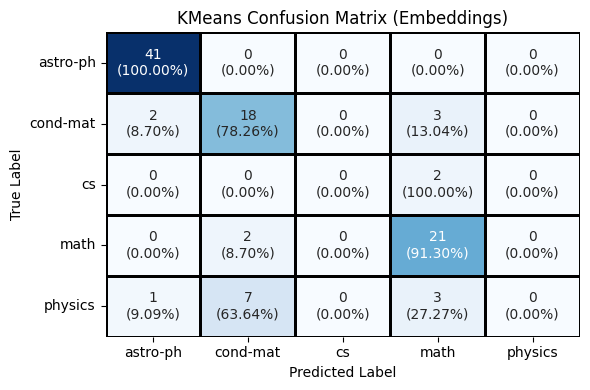

In [41]:
import os
os.makedirs("pdf/Figures", exist_ok=True)

# Draw confusion matrices
plot_confusion_matrix(y_test, km_bow_labels, sorted_labels, "KMeans Confusion Matrix (Bag of Words)", save_path="pdf/Figures/kmeans_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, km_tfidf_labels, sorted_labels, "KMeans Confusion Matrix (TF-IDF)", save_path="pdf/Figures/kmeans_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, km_embeddings_labels, sorted_labels, "KMeans Confusion Matrix (Embeddings)", save_path="pdf/Figures/kmeans_embeddings_confusion_matrix.pdf")

# KNN Classifier

## K-Nearest Neighbors (KNN) là một thuật toán phân loại đơn giản và hiệu quả, nó phân loại một điểm dữ liệu dựa trên lớp đa số của k láng giềng gần nhất trong không gian đặc trưng.

In [73]:
def train_and_test_knn(X_train, y_train, X_test, y_test, n_neighbors: int = 5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [74]:
knn_bow_labels, knn_bow_accuracy, knn_bow_report = train_and_test_knn(X_train_bow, y_train, X_test_bow, y_test)
knn_tfidf_labels, knn_tfidf_accuracy, knn_tfidf_report = train_and_test_knn(X_train_tfidf, y_train, X_test_tfidf, y_test)
knn_embeddings_labels, knn_embeddings_accuracy, knn_embeddings_report = train_and_test_knn(X_train_embeddings, y_train, X_test_embeddings, y_test)

print("Accuracies for KNN:")
print(f"Bag of Words: {knn_bow_accuracy:.4f}")
print(f"TF-IDF: {knn_tfidf_accuracy:.4f}")
print(f"Embeddings: {knn_embeddings_accuracy:.4f}")

Accuracies for KNN:
Bag of Words: 0.3700
TF-IDF: 0.7900
Embeddings: 0.7800


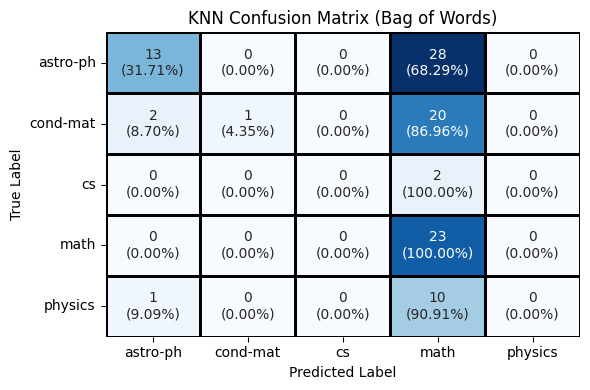

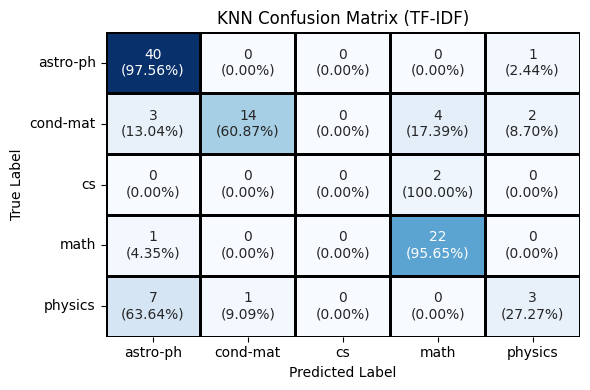

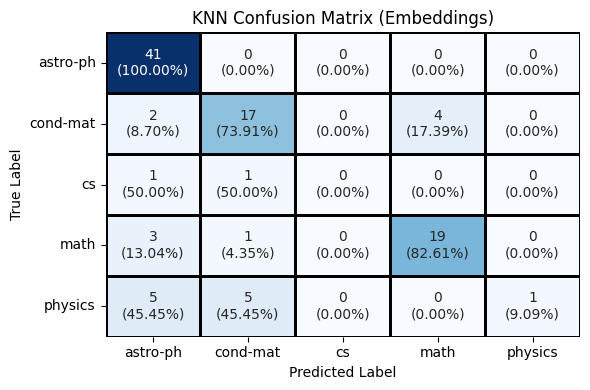

In [75]:
plot_confusion_matrix(y_test, knn_bow_labels, sorted_labels, "KNN Confusion Matrix (Bag of Words)", "pdf/Figures/knn_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, knn_tfidf_labels, sorted_labels, "KNN Confusion Matrix (TF-IDF)", "pdf/Figures/knn_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, knn_embeddings_labels, sorted_labels, "KNN Confusion Matrix (Embeddings)", "pdf/Figures/knn_embeddings_confusion_matrix.pdf")

# Decision Tree

## Decision Tree là một thuật toán phân loại dựa trên cấu trúc cây, nó phân chia dữ liệu thành các nhánh dựa trên các đặc trưng của dữ liệu để đưa ra quyết định cuối cùng.

In [76]:
def train_and_test_decision_tree(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [77]:
dt_bow_labels, dt_bow_accuracy, dt_bow_report = train_and_test_decision_tree(X_train_bow, y_train, X_test_bow, y_test)
dt_tfidf_labels, dt_tfidf_accuracy, dt_tfidf_report = train_and_test_decision_tree(X_train_tfidf, y_train, X_test_tfidf, y_test)
dt_embeddings_labels, dt_embeddings_accuracy, dt_embeddings_report = train_and_test_decision_tree(X_train_embeddings, y_train, X_test_embeddings, y_test)

print("Accuracies for Decision Tree:")
print(f"Bag of Words: {dt_bow_accuracy:.4f}")
print(f"TF-IDF: {dt_tfidf_accuracy:.4f}")
print(f"Embeddings: {dt_embeddings_accuracy:.4f}")

Accuracies for Decision Tree:
Bag of Words: 0.6200
TF-IDF: 0.6500
Embeddings: 0.5800


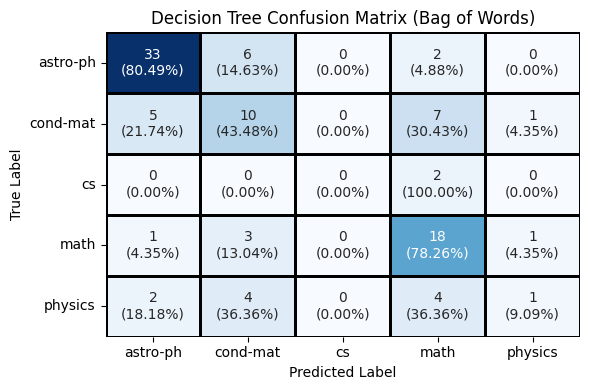

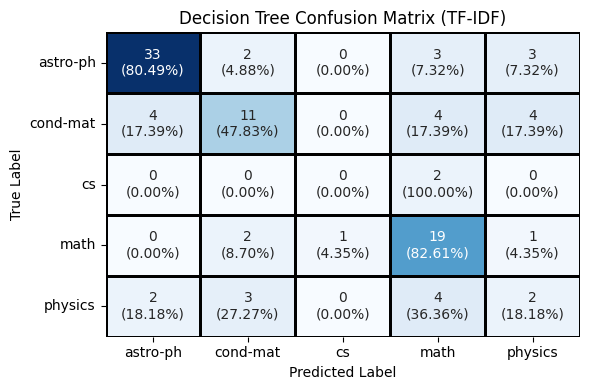

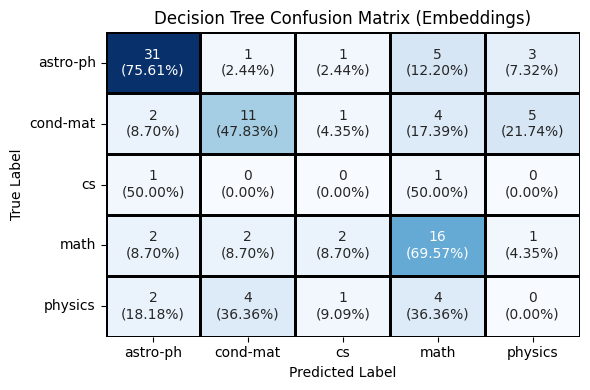

In [78]:
plot_confusion_matrix(y_test, dt_bow_labels, sorted_labels, "Decision Tree Confusion Matrix (Bag of Words)", "pdf/Figures/dt_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, dt_tfidf_labels, sorted_labels, "Decision Tree Confusion Matrix (TF-IDF)", "pdf/Figures/dt_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, dt_embeddings_labels, sorted_labels, "Decision Tree Confusion Matrix (Embeddings)", "pdf/Figures/dt_embeddings_confusion_matrix.pdf")

# Naive Bayes

## Naive Bayes là một thuật toán phân loại dựa trên định lý Bayes, nó giả định rằng các đặc trưng của dữ liệu là độc lập với nhau

In [79]:
from sklearn.naive_bayes import GaussianNB

def train_and_test_naive_bayes(X_train, y_train, X_test, y_test):
    nb = GaussianNB()

    # Naive Bayes requires input to be in dense format
    X_train_dense = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
    X_test_dense = X_test.toarray() if hasattr(X_test, 'toarray') else X_test

    nb.fit(X_train_dense, y_train)
    y_pred = nb.predict(X_test_dense)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [80]:
nb_bow_labels, nb_bow_accuracy, nb_bow_report = train_and_test_naive_bayes(X_train_bow, y_train, X_test_bow, y_test)
nb_tfidf_labels, nb_tfidf_accuracy, nb_tfidf_report = train_and_test_naive_bayes(X_train_tfidf, y_train, X_test_tfidf, y_test)
nb_embeddings_labels, nb_embeddings_accuracy, nb_embeddings_report = train_and_test_naive_bayes(X_train_embeddings, y_train, X_test_embeddings, y_test)

print("Accuracies for Naive Bayes:")
print(f"Bag of Words: {nb_bow_accuracy:.4f}")
print(f"TF-IDF: {nb_tfidf_accuracy:.4f}")
print(f"Embeddings: {nb_embeddings_accuracy:.4f}")

Accuracies for Naive Bayes:
Bag of Words: 0.7400
TF-IDF: 0.7500
Embeddings: 0.8400


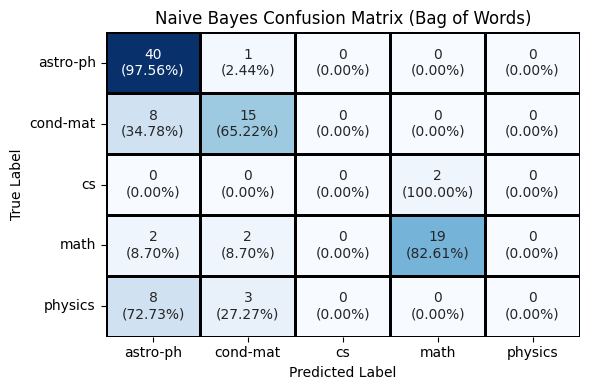

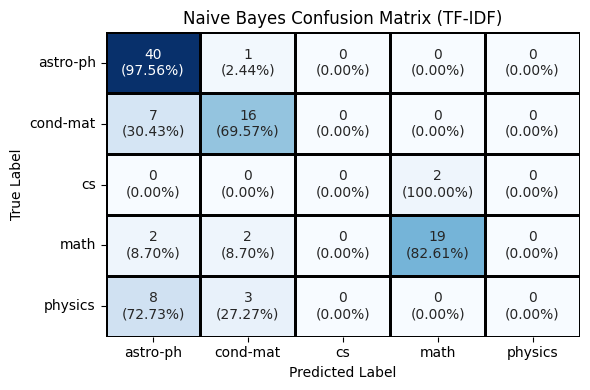

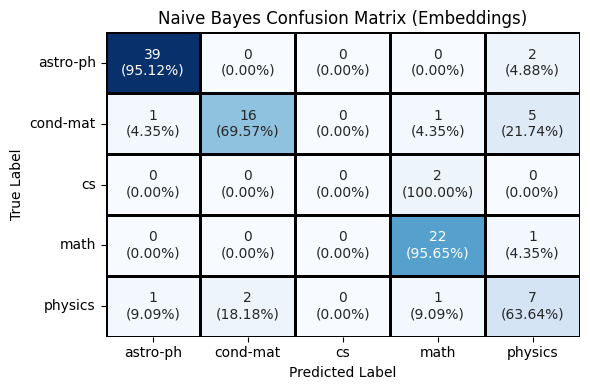

In [81]:
plot_confusion_matrix(y_test, nb_bow_labels, sorted_labels, "Naive Bayes Confusion Matrix (Bag of Words)", "pdf/Figures/nb_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, nb_tfidf_labels, sorted_labels, "Naive Bayes Confusion Matrix (TF-IDF)", "pdf/Figures/nb_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, nb_embeddings_labels, sorted_labels, "Naive Bayes Confusion Matrix (Embeddings)", "pdf/Figures/nb_embeddings_confusion_matrix.pdf")

# Random Forest

## Random Forest là một thuật toán học máy mạnh mẽ, nó cải thiện độ chính xác dự đoán bằng cách kết hợp đầu ra của nhiều decision trees độc lập từ các mẫu ngẫu nhiên của dữ liệu huấn luyện thông qua quá trình bootstrapping. Khi đưa ra dự đoán, Random Forest sẽ tổng hợp kết quả của các decision trees này- bằng majority vote cho các bài toán phân loại hoặc bằng cách lấy trung bình cho các bài toán hồi quy.

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
def train_and_test_random_forest(X_train, y_train, X_test, y_test, n_estimators: int = 100):
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [43]:
rf_bow_labels, rf_bow_accuracy, rf_bow_report = train_and_test_random_forest(X_train_bow, y_train, X_test_bow, y_test)
rf_tfidf_labels, rf_tfidf_accuracy, rf_tfidf_report = train_and_test_random_forest(X_train_tfidf, y_train, X_test_tfidf, y_test)
rf_embeddings_labels, rf_embeddings_accuracy, rf_embeddings_report = train_and_test_random_forest(X_train_embeddings, y_train, X_test_embeddings, y_test)

print("Accuracies for Random Forest:")
print(f"Bag of Words: {rf_bow_accuracy:.4f}")
print(f"TF-IDF: {rf_tfidf_accuracy:.4f}")
print(f"Embeddings: {rf_embeddings_accuracy:.4f}")

Accuracies for Random Forest:
Bag of Words: 0.7300
TF-IDF: 0.7300
Embeddings: 0.7800


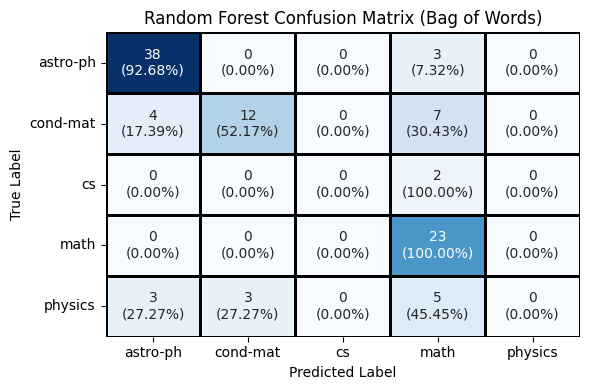

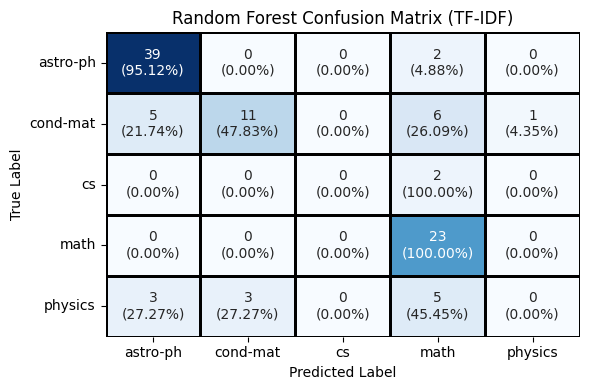

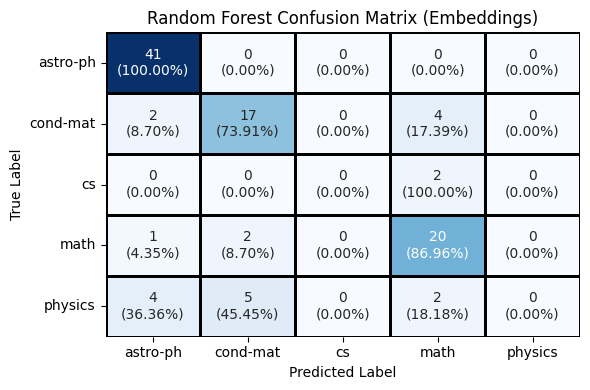

In [44]:
# Draw confusion matrices
plot_confusion_matrix(y_test, rf_bow_labels, sorted_labels, "Random Forest Confusion Matrix (Bag of Words)", "pdf/Figures/rf_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, rf_tfidf_labels, sorted_labels, "Random Forest Confusion Matrix (TF-IDF)", "pdf/Figures/rf_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, rf_embeddings_labels, sorted_labels, "Random Forest Confusion Matrix (Embeddings)", "pdf/Figures/rf_embeddings_confusion_matrix.pdf")

# AdaBoost

## AdaBoost, hay Adaptive Boosting, là một thuật toán học máy kết hợp nhiều mô hình học đơn giản và "yếu"để tạo ra một mô hình "mạnh"có độ chính xác cao. Nó hoạt động bằng cách huấn luyện lặp đi lặp lại các mô hình yếu này, với mỗi mô hình tiếp theo tập trung nhiều hơn vào các ví dụ bị phân loại sai từ các mô hình trước đó bằng cách tăng trọng số của chúng. Dự đoán cuối cùng là trung bình có trọng số của các dự đoán từ tất cả các mô hình yếu.

In [56]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [45]:
def train_and_test_adaboost(X_train, y_train, X_test, y_test, n_estimators: int = 50):
    ada = AdaBoostClassifier(n_estimators=n_estimators, random_state=42)
    ada.fit(X_train, y_train)

    y_pred = ada.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [48]:
ada_bow_labels, ada_bow_accuracy, ada_bow_report = train_and_test_adaboost(X_train_bow, y_train, X_test_bow, y_test)
ada_tfidf_labels, ada_tfidf_accuracy, ada_tfidf_report = train_and_test_adaboost(X_train_tfidf, y_train, X_test_tfidf, y_test)
ada_embeddings_labels, ada_embeddings_accuracy, ada_embeddings_report = train_and_test_adaboost(X_train_embeddings, y_train, X_test_embeddings, y_test)

print("Accuracies for AdaBoost:")
print(f"Bag of Words: {ada_bow_accuracy:.4f}")
print(f"TF-IDF: {ada_tfidf_accuracy:.4f}")
print(f"Embeddings: {ada_embeddings_accuracy:.4f}")

Accuracies for AdaBoost:
Bag of Words: 0.6000
TF-IDF: 0.5800
Embeddings: 0.6300


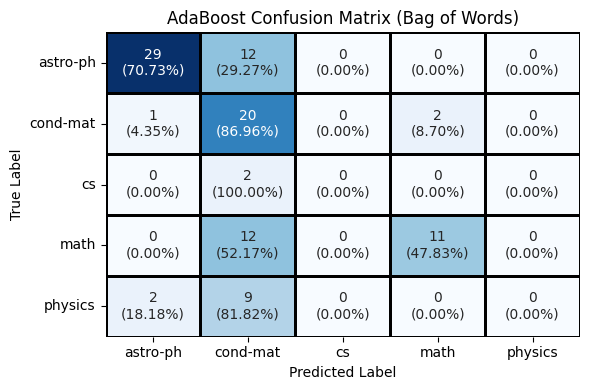

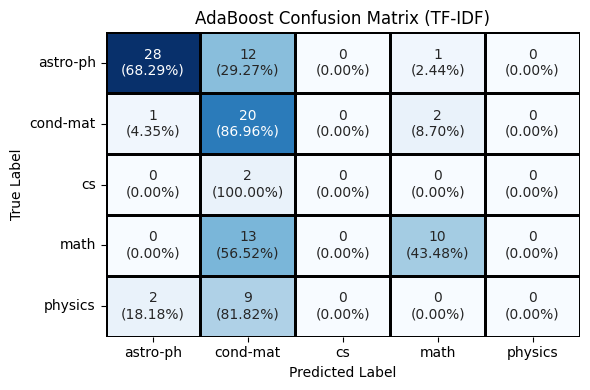

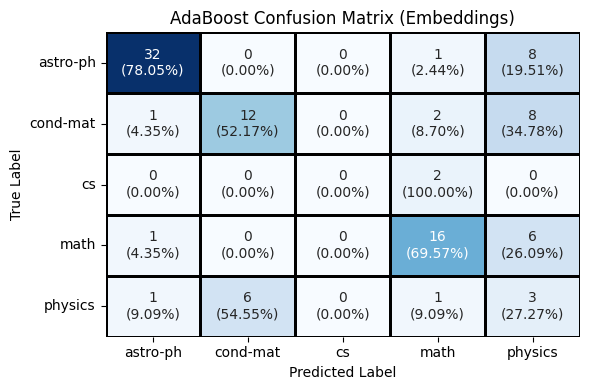

In [49]:
plot_confusion_matrix(y_test, ada_bow_labels, sorted_labels, "AdaBoost Confusion Matrix (Bag of Words)", "pdf/Figures/ada_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, ada_tfidf_labels, sorted_labels, "AdaBoost Confusion Matrix (TF-IDF)", "pdf/Figures/ada_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, ada_embeddings_labels, sorted_labels, "AdaBoost Confusion Matrix (Embeddings)", "pdf/Figures/ada_embeddings_confusion_matrix.pdf")

# Gradient Boosting

## Gradient boosting là một kỹ thuật học máy tập hợp, xây dựng các cây quyết định (hoặc các mô hình yếu khác) theo trình tự, với mỗi cây mới sửa lỗi của các cây trước đó để tạo thành một mô hình dự đoán mạnh mẽ tổng thể. Nó hoạt động bằng cách lặp đi lặp lại việc tối thiểu hóa một hàm mất mát, sử dụng gradient để hướng dẫn việc huấn luyện mỗi mô hình con mới. Việc sử dụng gradient boosting có thể tốn kém về mặt tính toán và dễ bị overfitting, đòi hỏi việc điều chỉnh hyperparameter cẩn thận.

In [50]:
def train_and_test_gradient_boosting(X_train, y_train, X_test, y_test, n_estimators: int = 100):
    gb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
    gb.fit(X_train, y_train)

    y_pred = gb.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [51]:
gb_bow_labels, gb_bow_accuracy, gb_bow_report = train_and_test_gradient_boosting(X_train_bow, y_train, X_test_bow, y_test)
gb_tfidf_labels, gb_tfidf_accuracy, gb_tfidf_report = train_and_test_gradient_boosting(X_train_tfidf, y_train, X_test_tfidf, y_test)
gb_embeddings_labels, gb_embeddings_accuracy, gb_embeddings_report = train_and_test_gradient_boosting(X_train_embeddings, y_train, X_test_embeddings, y_test)

print("Accuracies for Gradient Boosting:")
print(f"Bag of Words: {gb_bow_accuracy:.4f}")
print(f"TF-IDF: {gb_tfidf_accuracy:.4f}")
print(f"Embeddings: {gb_embeddings_accuracy:.4f}")

Accuracies for Gradient Boosting:
Bag of Words: 0.7700
TF-IDF: 0.7200
Embeddings: 0.8100


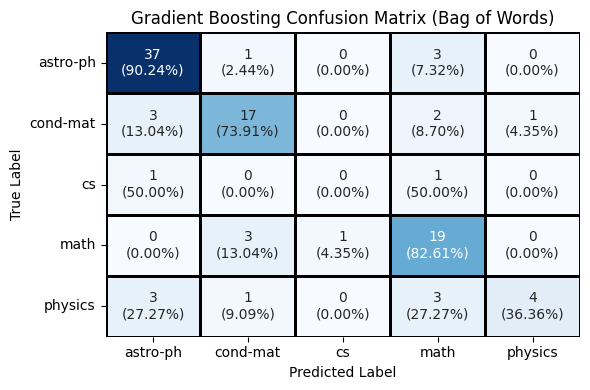

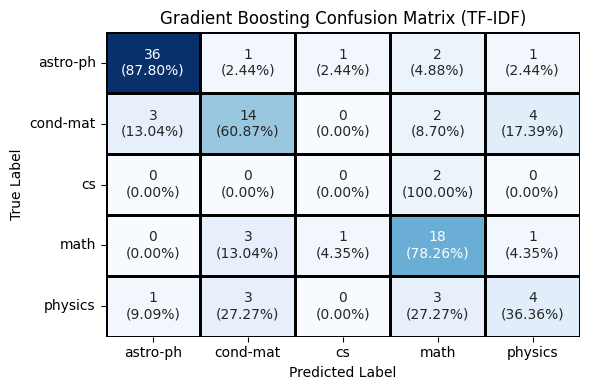

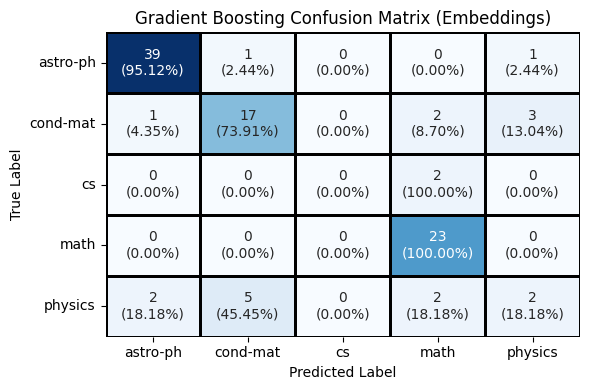

In [52]:
plot_confusion_matrix(y_test, gb_bow_labels, sorted_labels, "Gradient Boosting Confusion Matrix (Bag of Words)", "pdf/Figures/gb_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, gb_tfidf_labels, sorted_labels, "Gradient Boosting Confusion Matrix (TF-IDF)", "pdf/Figures/gb_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, gb_embeddings_labels, sorted_labels, "Gradient Boosting Confusion Matrix (Embeddings)", "pdf/Figures/gb_embeddings_confusion_matrix.pdf")

# XBoost

## XGBoost là một thư viện học máy mã nguồn mở, được sử dụng rộng rãi vì cách triển khai tối ưu hóa và mở rộng của thuật toán gradient boosting cho các tác vụ như phân loại, hồi quy và xếp hạng. XGBoost nổi tiếng nhờ tốc độ, độ chính xác, cũng như khả năng xử lý các tập dữ liệu lớn thông qua xử lý song song và phân tán.

In [57]:
from xgboost import XGBClassifier

In [58]:
def train_and_test_xgboost(X_train, y_train, X_test, y_test, n_estimators: int = 100):
    xgb = XGBClassifier(
        n_estimators=n_estimators, use_label_encoder=False, eval_metric='mlogloss', random_state=42
    )
    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [59]:
xgb_bow_labels, xgb_bow_accuracy, xgb_bow_report = train_and_test_xgboost(X_train_bow, y_train, X_test_bow, y_test)
xgb_tfidf_labels, xgb_tfidf_accuracy, xgb_tfidf_report = train_and_test_xgboost(X_train_tfidf, y_train, X_test_tfidf, y_test)
xgb_embeddings_labels, xgb_embeddings_accuracy, xgb_embeddings_report = train_and_test_xgboost(X_train_embeddings, y_train, X_test_embeddings, y_test)

print("Accuracies for XGBoost:")
print(f"Bag of Words: {xgb_bow_accuracy:.4f}")
print(f"TF-IDF: {xgb_tfidf_accuracy:.4f}")
print(f"Embeddings: {xgb_embeddings_accuracy:.4f}")

Accuracies for XGBoost:
Bag of Words: 0.6700
TF-IDF: 0.7000
Embeddings: 0.7900


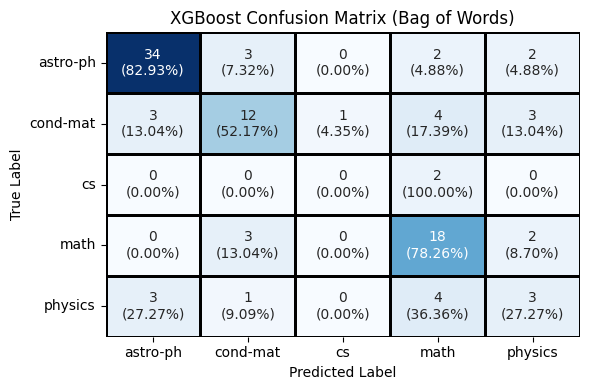

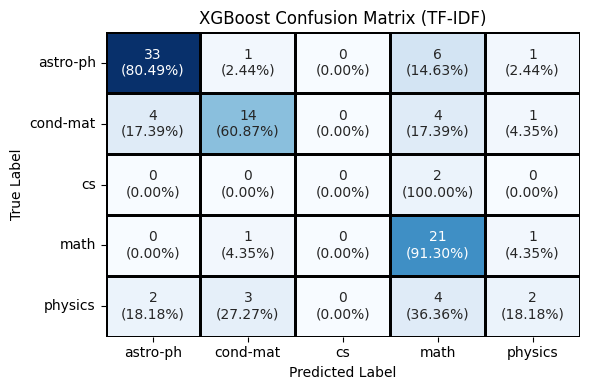

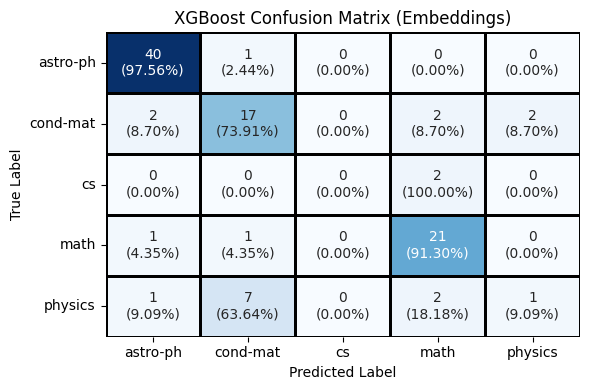

In [60]:
plot_confusion_matrix(y_test, xgb_bow_labels, sorted_labels, "XGBoost Confusion Matrix (Bag of Words)", "pdf/Figures/xgb_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, xgb_tfidf_labels, sorted_labels, "XGBoost Confusion Matrix (TF-IDF)", "pdf/Figures/xgb_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, xgb_embeddings_labels, sorted_labels, "XGBoost Confusion Matrix (Embeddings)", "pdf/Figures/xgb_embeddings_confusion_matrix.pdf")

# LightBGM

LightGBM (Light Gradient Boosting Machine) được xây dựng dựa trên thuật toán Gradient Boosting Decision Tree (GBDT). Đây là một framework học tăng cường theo gradient, tận dụng các thuật toán học dựa trên cây, đặc biệt là decision tree đã được tối ưu hóa. Đặc điểm và tối ưu hóa nổi bật của LightGBM được liệt kê như sau:

* Phát triển cây theo lá (Leaf-wise, Best-first): Khác với nhiều phương pháp triển khai GBDT khác thường mở rộng cây theo từng tầng (level-wise), LightGBM mở rộng cây theo lá. Điều này có nghĩa là nó sẽ chọn lá có độ giảm tổn thất (delta loss) lớn nhất để chia, giúp mô hình hội tụ nhanh hơn và tiềm năng đạt độ chính xác cao hơn.
* Thuật toán dựa trên histogram: LightGBM sử dụng thuật toán dựa trên histogram để tìm điểm chia tối ưu, từ đó rút ngắn đáng kể thời gian huấn luyện, đặc biệt với các tập dữ liệu lớn.
* Tiết kiệm bộ nhớ: Thiết kế hướng hiệu quả sử dụng bộ nhớ, phù hợp để xử lý dữ liệu ở quy mô lớn.
* Hỗ trợ học song song và phân tán: LightGBM hỗ trợ nhiều chiến lược huấn luyện song song và phân tán, giúp mở rộng khả năng xử lý cho các bài toán Big Data.





Gradient-based One-Side Sampling (GOSS) là một kỹ thuật được sử dụng trong thuật toán LightGBM để cải thiện hiệu quả huấn luyện các mô hình tăng cường gradient. Kỹ thuật này tập trung vào việc lựa chọn một tập hợp con các điểm dữ liệu dựa trên gradient của chúng, cho phép mô hình ưu tiên học từ các mẫu có nhiều thông tin nhất.

In [63]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

In [66]:
def train_and_test_lightgbm(X_train, y_train, X_test, y_test, n_estimators: int = 100):
  lgbm = lgb.LGBMClassifier(boosting_type = 'goss', n_estimators=n_estimators, random_state=42)
  lgbm.fit(X_train, y_train)

  y_pred = lgbm.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred, target_names = sorted_labels, output_dict = True)

  return y_pred, accuracy, report

In [68]:
lgbm_bow_labels, lgbm_bow_accuracy, lgbm_bow_report = train_and_test_lightgbm(X_train_bow, y_train, X_test_bow, y_test)
lgbm_tfidf_labels, lgbm_tfidf_accuracy, lgbm_tfidf_report = train_and_test_lightgbm(X_train_tfidf, y_train, X_test_tfidf, y_test)
lgbm_embeddings_labels, lgbm_embeddings_accuracy, lgbm_embeddings_report = train_and_test_lightgbm(X_train_embeddings, y_train, X_test_embeddings, y_test)

print("Accuracies for LightGBM:")
print(f"Bag of Words: {lgbm_bow_accuracy:.4f}")
print(f"TF-IDF: {lgbm_tfidf_accuracy:.4f}")
print(f"Embeddings: {lgbm_embeddings_accuracy:.4f}")

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 143
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -0.879477
[LightGBM] [Info] Start training from score -1.458865
[LightGBM] [Info] Start training from score -3.912023
[LightGBM] [Info] Start training

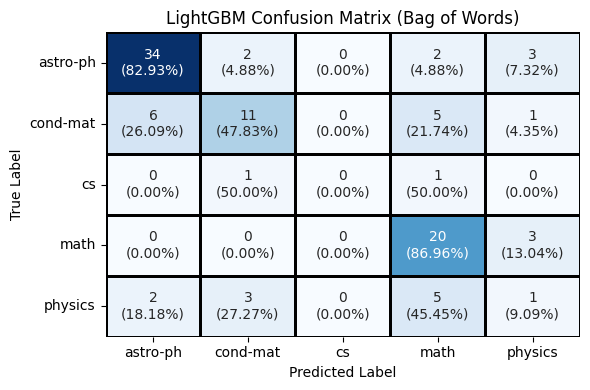

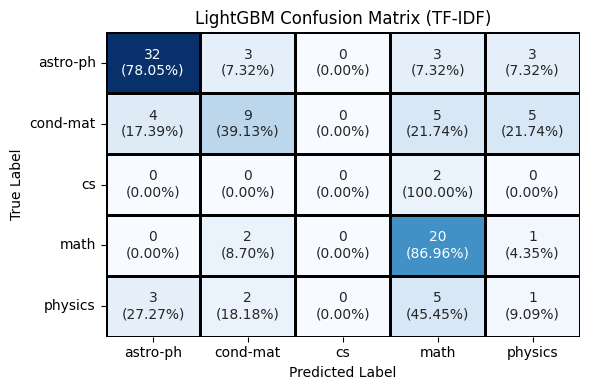

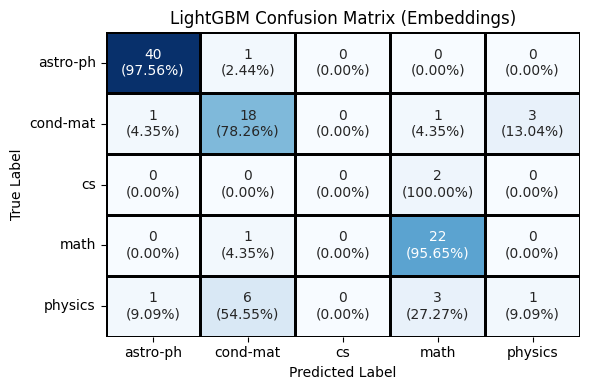

In [69]:
plot_confusion_matrix(y_test, lgbm_bow_labels, sorted_labels, "LightGBM Confusion Matrix (Bag of Words)", "pdf/Figures/lgbm_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, lgbm_tfidf_labels, sorted_labels, "LightGBM Confusion Matrix (TF-IDF)", "pdf/Figures/lgbm_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, lgbm_embeddings_labels, sorted_labels, "LightGBM Confusion Matrix (Embeddings)", "pdf/Figures/lgbm_embeddings_confusion_matrix.pdf")

# All results

In [83]:
model_accuracies = {
    "KMeans": {
        "Bag of Words": km_bow_accuracy,
        "TF-IDF": km_tfidf_accuracy,
        "Embeddings": km_embeddings_accuracy
    },
    "KNN": {
        "Bag of Words": knn_bow_accuracy,
        "TF-IDF": knn_tfidf_accuracy,
        "Embeddings": knn_embeddings_accuracy
    },
    "Decision Tree": {
        "Bag of Words": dt_bow_accuracy,
        "TF-IDF": dt_tfidf_accuracy,
        "Embeddings": dt_embeddings_accuracy
    },
    "Naive Bayes": {
        "Bag of Words": nb_bow_accuracy,
        "TF-IDF": nb_tfidf_accuracy,
        "Embeddings": nb_embeddings_accuracy
    },
    "Random Forest": {
        "Bag of Words": rf_bow_accuracy,
        "TF-IDF": rf_tfidf_accuracy,
        "Embeddings": rf_embeddings_accuracy
    },
    "AdaBoost": {
        "Bag of Words": ada_bow_accuracy,
        "TF-IDF": ada_tfidf_accuracy,
        "Embeddings": ada_embeddings_accuracy
    },
    "Gradient Boosting": {
        "Bag of Words": gb_bow_accuracy,
        "TF-IDF": gb_tfidf_accuracy,
        "Embeddings": gb_embeddings_accuracy
    },
    "XGBoost": {
        "Bag of Words": xgb_bow_accuracy,
        "TF-IDF": xgb_tfidf_accuracy,
        "Embeddings": xgb_embeddings_accuracy
    },
    "LightGBM": {
        "Bag of Words": lgbm_bow_accuracy,
        "TF-IDF": lgbm_tfidf_accuracy,
        "Embeddings": lgbm_embeddings_accuracy
    }
}

accuracy_df = pd.DataFrame(model_accuracies)
print(accuracy_df)

              KMeans   KNN  Decision Tree  Naive Bayes  Random Forest  \
Bag of Words    0.45  0.37           0.62         0.74           0.73   
TF-IDF          0.76  0.79           0.65         0.75           0.73   
Embeddings      0.80  0.78           0.58         0.84           0.78   

              AdaBoost  Gradient Boosting  XGBoost  LightGBM  
Bag of Words      0.60               0.77     0.67      0.66  
TF-IDF            0.58               0.72     0.70      0.62  
Embeddings        0.63               0.81     0.79      0.81  


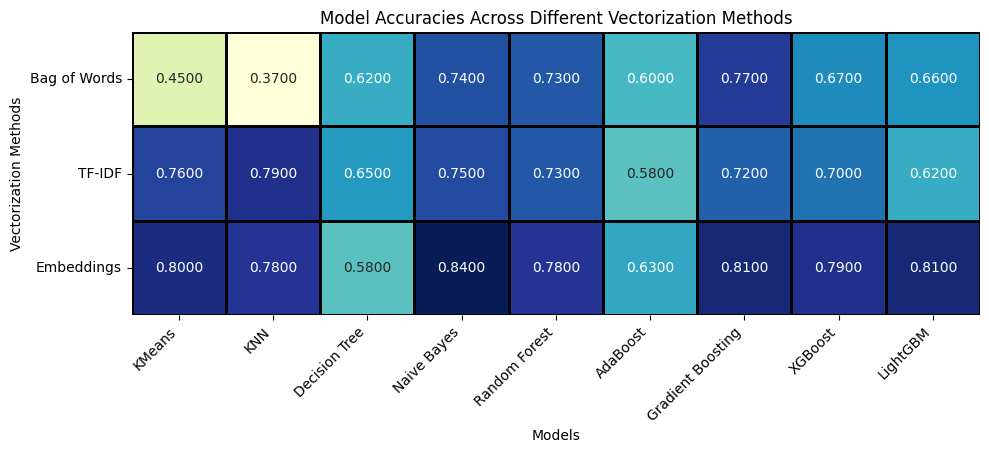

In [84]:
# plot accuracy_df as a heatmap with outline around each cell, and ensure each cell is square
plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_df, annot=True, fmt=".4f", cmap="YlGnBu", cbar=False, linewidths=1, linecolor='black', square=True)
plt.title("Model Accuracies Across Different Vectorization Methods")
plt.xlabel("Models")
# change the angle of x ticks to 45 degrees
plt.xticks(rotation=45, ha='right')
plt.ylabel("Vectorization Methods")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("pdf/Figures/model_accuracies_heatmap.pdf")
plt.show()

# Explain Model's Predictions with SHAP

## Explainable AI (XAI) sử dụng các giá trị Shapley, cụ thể là thông qua khuôn khổ SHAP (SHapley Additive exPlanations), để diễn giải các mô hình phân loại văn bản. Đối với bag-of-words (BOW), mỗi từ trong từ vựng trở thành một "người chơi" trong một trò chơi hợp tác. SHAP tính toán mức đóng góp trung bình của sự hiện diện (hoặc vắng mặt) của mỗi từ vào dự đoán phân loại của một văn bản cụ thể bằng cách so sánh tác động của nó trên tất cả các tập hợp con từ có thể có trong tài liệu. Điều này cho phép mô hình phân bổ công bằng kết quả dự đoán cho từng từ riêng lẻ, làm nổi bật những từ nào ảnh hưởng tích cực hoặc tiêu cực đến quyết định.

First, we prepare feature names for BoW, TF-IDF, and Word Embeddings representations

In [85]:
bow_vectorizer = CountVectorizer(
    stop_words="english",
    max_df=0.9,
    min_df=2,
    max_features=500
)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)
bow_features = bow_vectorizer.get_feature_names_out()

In [86]:
bow_features

array(['absorption', 'accretion', 'activity', 'addition', 'agreement',
       'algorithm', 'allows', 'analysis', 'analytic', 'anisotropy',
       'applications', 'applied', 'approach', 'approximation', 'area',
       'associated', 'assuming', 'asteroids', 'atomic', 'au', 'axis',
       'background', 'band', 'based', 'behavior', 'better', 'bias',
       'binaries', 'binary', 'black', 'boundary', 'brightness', 'bursts',
       'calculated', 'calculations', 'case', 'catalog', 'central',
       'certain', 'characteristic', 'class', 'classical', 'clearly',
       'close', 'cloud', 'cluster', 'clusters', 'cm', 'coefficient',
       'coefficients', 'cold', 'combined', 'common', 'compact',
       'companion', 'compared', 'comparison', 'complete', 'complex',
       'component', 'components', 'condition', 'conditions',
       'conductance', 'confirm', 'confirmed', 'conjecture', 'consider',
       'considered', 'consistent', 'constant', 'construct', 'contains',
       'continuum', 'core', 'correl

In [87]:
X_train_bow, X_test_bow = np.array(X_train_bow.toarray()), np.array(X_test_bow.toarray())

In [88]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_bow, y_train)

y_pred = dt.predict(X_test_bow)

accuracy = accuracy_score(y_test, y_pred)

In [89]:
accuracy

0.61

In [90]:
bow_explainer = shap.Explainer(dt.predict, X_train_bow, feature_names=bow_features, max_evals=2 * len(bow_features) + 1)
bow_shap_values = bow_explainer(X_test_bow)

PermutationExplainer explainer: 101it [00:43,  1.98it/s]


Then, we draw the summary plot for the SVM model with TF-IDF representation to observe the overall impact of features on model output.

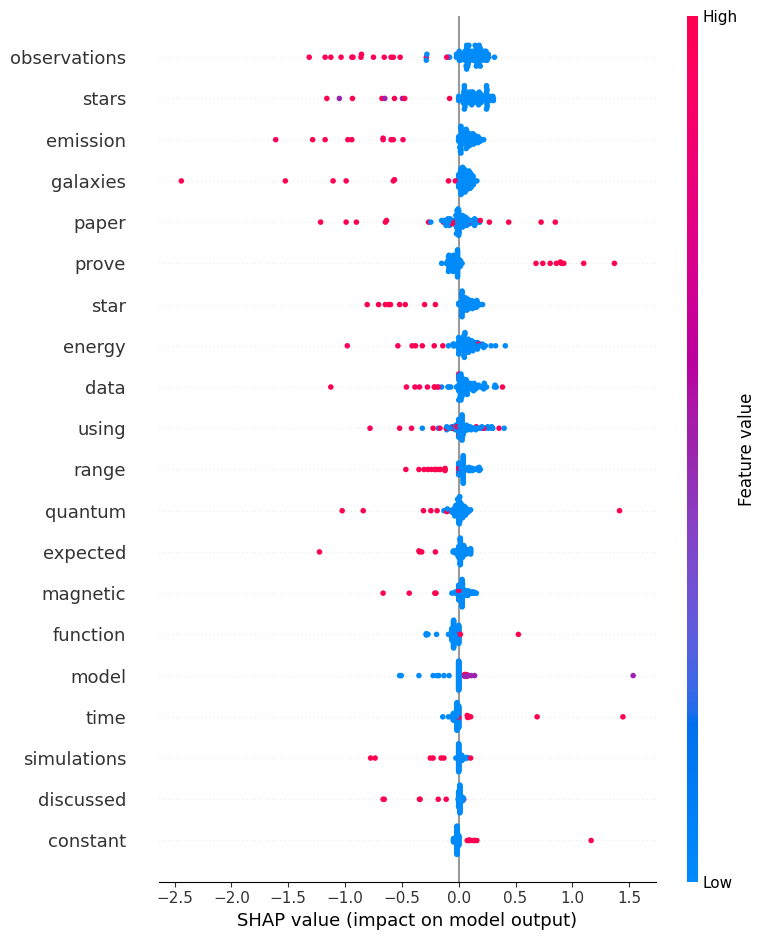

In [91]:
shap.summary_plot(bow_shap_values, feature_names=bow_features, show=False, max_display=20, class_names=sorted_labels)

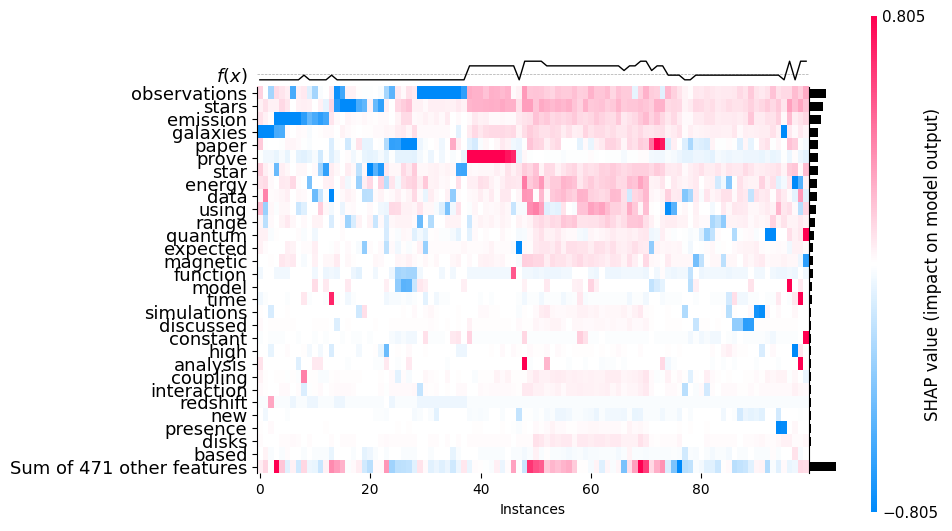

<Axes: xlabel='Instances'>

In [92]:
shap.plots.heatmap(bow_shap_values, max_display=30)

For each unique label in the test subset, we select the first sample of that label and generate a force plot to visualize the contribution of each feature to the model's prediction for that specific publication topic.

SHAP values for class 'astro-ph' (index 1 in test set):


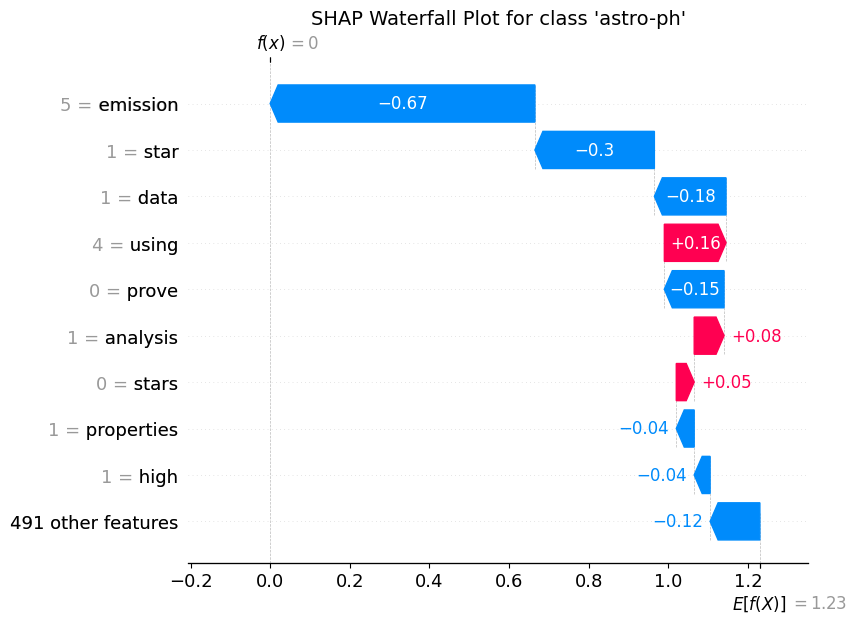



SHAP values for class 'cond-mat' (index 2 in test set):


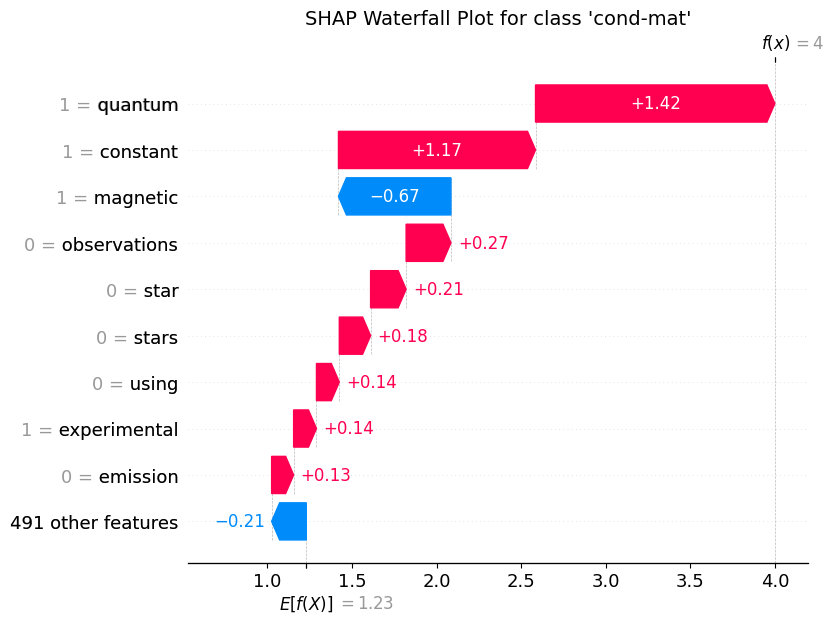



SHAP values for class 'cs' (index 29 in test set):


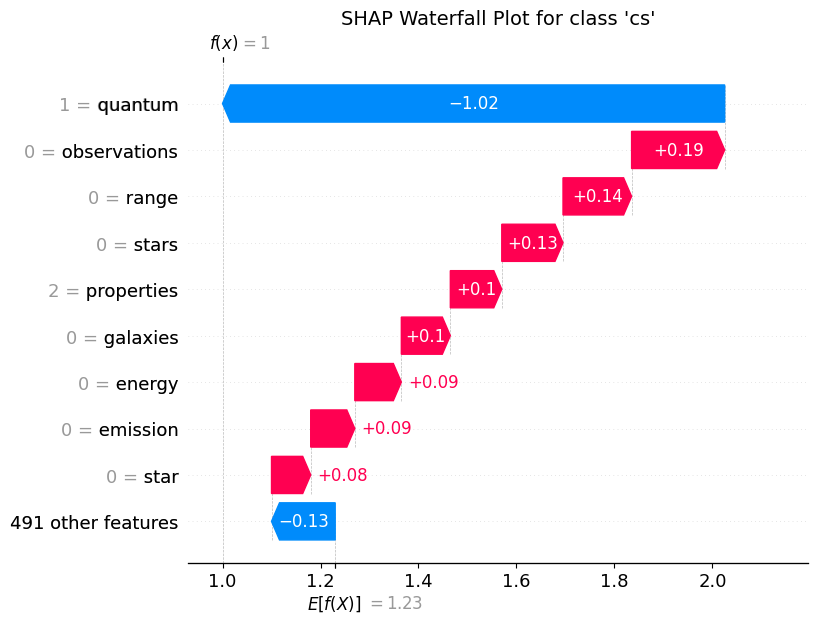



SHAP values for class 'math' (index 0 in test set):


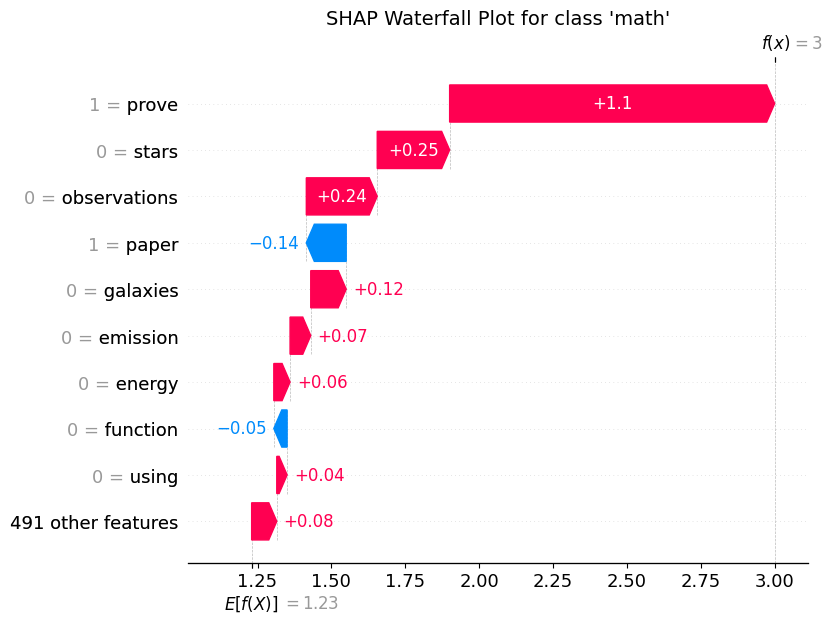



SHAP values for class 'physics' (index 9 in test set):


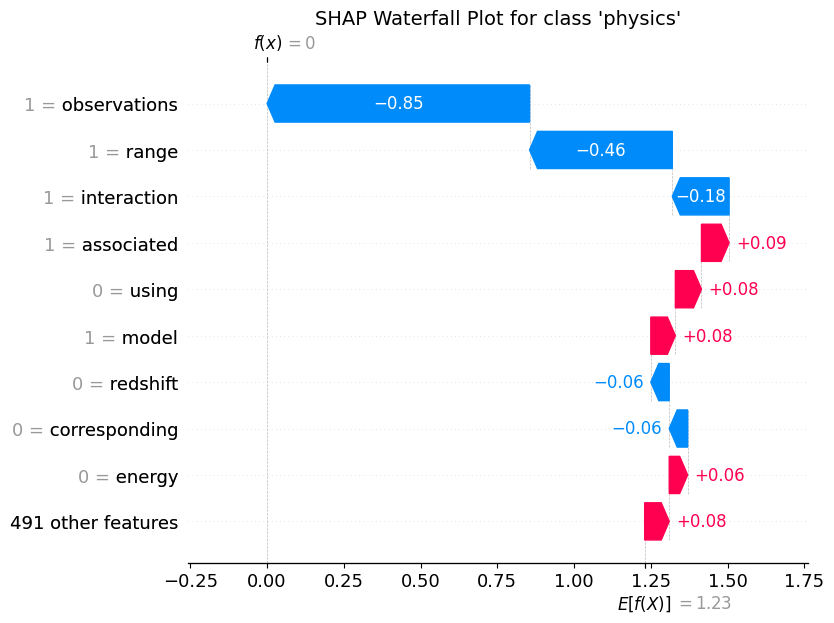

In [93]:
for i in id_to_label:
    class_idx = np.where(np.array(y_test) == i)[0][0]
    print(f"SHAP values for class '{id_to_label[i]}' (index {class_idx} in test set):")

    # Plot title with bigger font
    plt.title(f"SHAP Waterfall Plot for class '{id_to_label[i]}'", fontsize=14)

    shap.plots.waterfall(bow_shap_values[class_idx], max_display=10)
    print("\n")

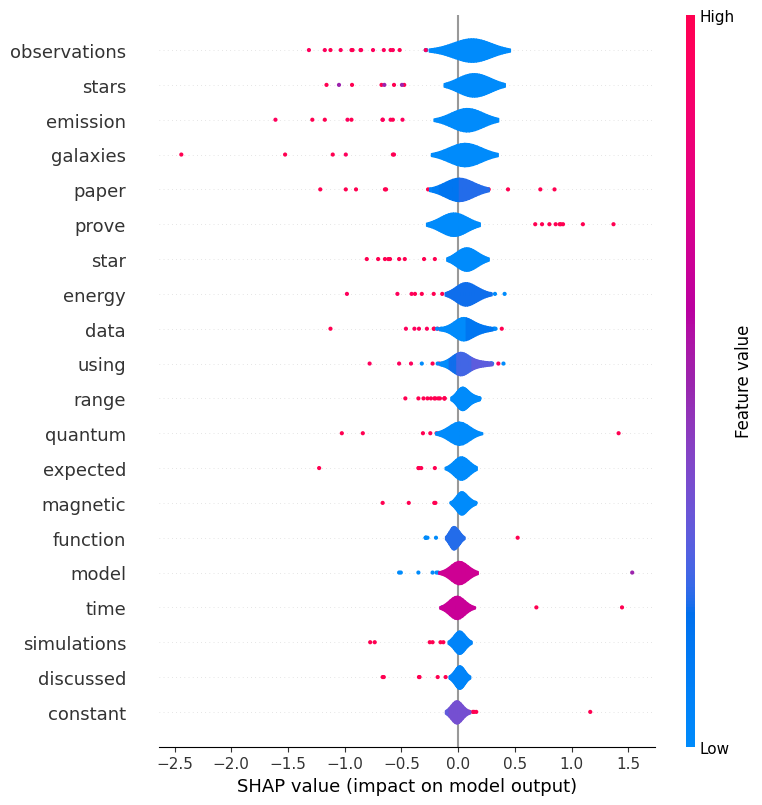

In [94]:
feat_names = list(bow_features)
shap.plots.violin(bow_shap_values, feature_names=feat_names)